# BYOL

## SETUP

In [3]:
%cd ~/Documents/TESI/FOLDER_CINECA/
%load_ext autoreload
%autoreload 2

/home/zano/Documents/TESI/FOLDER_CINECA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/zano/Documents/TESI/FOLDER_CINECA/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/zano/Documents/TESI/FOLDER_CINECA/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import os
import re
import tifffile
import glob
import random
import torch
import pytorch_lightning as pl
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from configs.ConfigLoader import ConfigLoader
from utils.train_functions import (
# train_epoch,
# val_epoch,
# print_model_summary,
# plot_cv_results,
# train_epoch_mixUp,
# print_layers,
# oversample_minority,
# undersample_majority,
# freeze_layers_up_to,
# freeze_layers_up_to_progressive_ft,
train_epoch_vit,
val_epoch_vit,
)

import utils.transformations_functions as tf
# Removed redundant import: from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
# import torch.nn.functional as F
# from monai.visualize.class_activation_maps import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False:


2.10.0.dev20251008+cu128
1.4.0


In [14]:
from utils.setup_functions import set_environment_flags
# Example usage:
# Set the DATA_ROOT environment variable before calling get_data_directory
os.environ["DATA_ROOT"] = "/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS"
os.environ["PROJ_ROOT"] = "/home/zano/Documents/TESI/FOLDER_CINECA"
os.environ["MLFLOW_TRACKING_URI"] = "file:/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
# kaggle,gdrive,linux = environment_flags["kaggle"], environment_flags["gdrive"], environment_flags["linux"]
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

In [15]:
# Now you can proceed with your existing code
from utils.directory_functions import get_data_directory, get_base_directory
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))

data_dir = get_data_directory(num_input_channels=num_input_channels)
print("data dir:", data_dir)
base_dir = get_base_directory()
print("base_dir:", base_dir)

# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri()
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

data dir: /home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP
base_dir: /home/zano/Documents/TESI/FOLDER_CINECA
Starting MLflow UI on port file:/home/zano/Documents/TESI/FOLDER_CINECA/mlruns …  logs → mlflow_ui.log


# DATA EXTRACTION

In [16]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [22]:
print(f"Initial class_names set to: {class_names}")

Initial class_names set to: ['MSA-P', 'PD']


In [30]:
## Paths of ALL images into a numpy array without labels used for SSL
def from_tif_folder_to_np_paths_array(folder_path: str) -> np.ndarray:
    """
    Load all .tif images from a folder into a numpy array.
    """
    image_paths = glob.glob(os.path.join(folder_path, "*.tif"))
    image_paths_np = np.array(image_paths)
    print(f"Number of images in {folder_path}: {len(image_paths)}")
    return image_paths_np

cfg = ConfigLoader(config_path=f"configs/ssl/byol_resnet18_{num_input_channels}c.yaml")

# all_images_folder_path = os.path.join(data_dir, "ALL")
# all_images_paths = from_tif_folder_to_np_paths_array(all_images_folder_path)
# print("Number of images in ALL folder:", len(all_images_paths))

Configuration loaded from configs/ssl/base.yaml
Configuration: {'dataset': {'class_names': ['MSA', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6, 'lr_discovery_folds': 4}, 'data_augmentation': {'resize_spatial_size': [512, 512], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1, 'crop_size': [256, 256], 'use_color_transforms': False, 'intensity_augmentation_preset': 'heavy', 'use_crop': False, 'crop_percentage': 0.95}, 'data_loading': {'batch_size': 32, 'num_workers': 4}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1, 'library': 'monai'}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'transfer_learning': False, 'fre

In [31]:
## Paths of ALL images into a numpy array without labels used for SSL
print(class_names)
if class_names == ['MSA-P', 'PD']:
    ssl_images_folder_path = os.path.join(data_dir, f"PRETRAINING_MSAP_VS_PD")
else:
    raise ValueError(f"Unexpected class_names: {class_names}")

# images used for pretraining
ssl_images_paths_np = from_tif_folder_to_np_paths_array(ssl_images_folder_path)
print(f"Number of images in {ssl_images_folder_path} folder:", len(ssl_images_paths_np))

['MSA-P', 'PD']
Number of images in /home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/PRETRAINING_MSAP_VS_PD: 522
Number of images in /home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/PRETRAINING_MSAP_VS_PD folder: 522


{'MSA-P': '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/MSA-P', 'PD': '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/PD'}
Class directories:
{'MSA-P': '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/MSA-P', 'PD': '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/PD'}
MSA-P images (before filtering): 'gh' count: 306, 'vaso' count: 0
After removing 'vaso', MSA-P images: 'gh' count: 306, 'vaso' count: 0
PD images (before filtering): 'gh' count: 249, 'vaso' count: 0
After removing 'vaso', PD images: 'gh' count: 249, 'vaso' count: 0


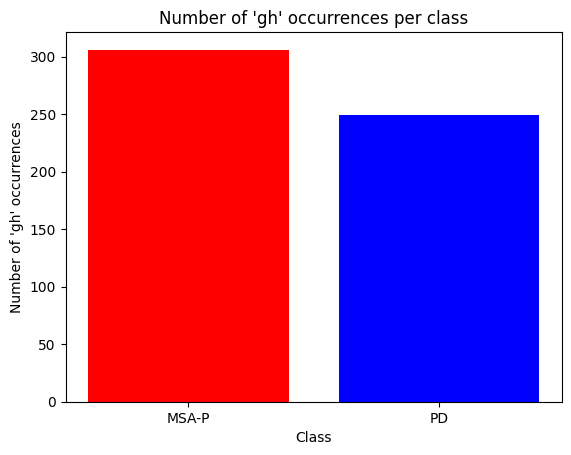


Checking image shapes:
MSA-P image: 4092.lif_-_4092_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_2_blk01_Z9-13.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA-P image: 4092.lif_-_4092_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_2_blk02_Z14-18.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA-P image: 4092.lif_-_4092_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_2_blk03_Z19-23.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA-P image: 4092.lif_-_4092_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_2_blk04_Z24-28.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA-P image: 4092.lif_-_4092_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_2_blk05_Z29-33.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA-P image: 4092.lif_-_4092_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_2_blk06_Z34-38.tif  dtype: uint8, shape: (4, 1024, 1024)
MSA-P image: 4092.lif_-_4092_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_blk01_Z6-10.

In [26]:
# Create a dictionary mapping each class to its directory
class_dirs = {}
three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    image_paths = [path for path in image_paths if 'vaso' not in os.path.basename(path).lower()]
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts, key=counts.get)
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

Original dataset size: 555
Original label distribution: {np.int64(0): np.int64(306), np.int64(1): np.int64(249)}

Aiming for a balanced test set with 249 samples per class.
Total balanced test set size will be: 498
Test set size: 498

Test set distribution: {np.int64(0): np.int64(249), np.int64(1): np.int64(249)}


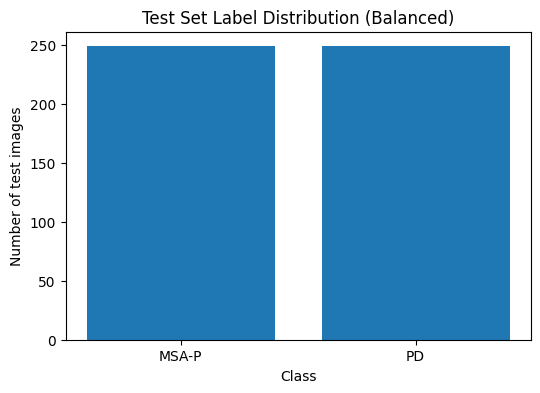


Test set counts and percentages:
MSA-P: 249 images (50.0% of test set)
PD: 249 images (50.0% of test set)


In [27]:
# --- Your Split Logic for 50/50 distribution in test set ---
print("Original dataset size:", len(images_paths_np))

# Find unique labels and their counts in the original dataset
unique_labels, counts = np.unique(labels_np, return_counts=True)
original_distribution = dict(zip(unique_labels, counts))
print(f"Original label distribution: {original_distribution}")

# Determine the maximum possible size for a balanced test set per class
# This is limited by the count of the smallest class
if len(unique_labels) > 1:
    min_class_count = min(counts)
    # We want a balanced test set, so take 'min_class_count' samples from each class
    test_samples_per_class = min_class_count
    total_balanced_test_size = test_samples_per_class * len(unique_labels)

    print(f"\nAiming for a balanced test set with {test_samples_per_class} samples per class.")
    print(f"Total balanced test set size will be: {total_balanced_test_size}")

    test_indices = []
    train_indices = []

    # Iterate through each class to split
    for label in unique_labels:
        # Get the indices in the original array that correspond to the current class
        # print ( labels_np == label) # returns a boolean array
        class_indices = np.where(labels_np == label)[0]  #use the boolean array to get the indices where cond is true 
        # print(f"\nClass {label} indices: {class_indices}") #retuns the indices of the class in the original array and the boolarray so we use [0] to get the indices

        # Randomly select a fixed number of indices for the test set from this class
        # Use np.random.choice with replace=False for sampling without replacement
        # Set a random_state for reproducibility if needed
        rng = np.random.default_rng(42) # Use new random generator recommended over np.random.seed
        test_class_indices = rng.choice(
            class_indices,
            size=test_samples_per_class,
            replace=False
        )
        test_indices.extend(test_class_indices)

    # Convert lists of indices to NumPy arrays
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)

    # Shuffle the indices to mix up the classes in the final arrays (optional but good practice)
    # rng.shuffle(test_indices)
    # rng.shuffle(train_indices)

    balanced_test_images_paths = images_paths_np[test_indices]
    balanced_test_true_labels = labels_np[test_indices]
    print(f"Test set size: {len(balanced_test_images_paths)}")

    # Verify the test set distribution
    test_unique_labels, test_counts = np.unique(balanced_test_true_labels, return_counts=True)
    test_distribution = dict(zip(test_unique_labels, test_counts))
    print(f"\nTest set distribution: {test_distribution}")


    plt.figure(figsize=(6, 4))
    # Use test_unique_labels and test_counts for the bar plot
    labels_for_plot = [class_names[label] if 'class_names' in locals() else f"Label {label}" for label in test_unique_labels]
    plt.bar(labels_for_plot, test_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of test images")
    plt.title("Test Set Label Distribution (Balanced)")
    plt.show()

    # Print counts and percentages for the balanced test set
    print("\nTest set counts and percentages:")
    for label, count in zip(test_unique_labels, test_counts):
         class_name = class_names[label] if 'class_names' in locals() else f"Label {label}"
         print(f"{class_name}: {count} images ({count/len(balanced_test_true_labels):.1%} of test set)")

else:
    print("Cannot perform a balanced split with less than two unique classes.")

train images paths: ['/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/MSA-P/7132.lif_-_7132_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_blk02_Z12-16.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/PD/6459.lif_-_6459_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh__n2_blk01_Z8-12.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/PD/6616.lif_-_6616_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh__n2_blk02_Z14-18.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/MSA-P/6179_gh.tif_blk05_Z27-31.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/MSA-P/7811.lif_-_7811_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh2_blk05_Z29-33.tif'
 '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/4c_MIP/MSA-P/6237.lif_-_6237_DL_VIP_red_Sinapto_gr_TH_b_D_grey_63x_z_2_pinhole_1_z_05_gh_blk03_Z18-22.tif'
 '/home/zano/Documents/TESI/FOLDER

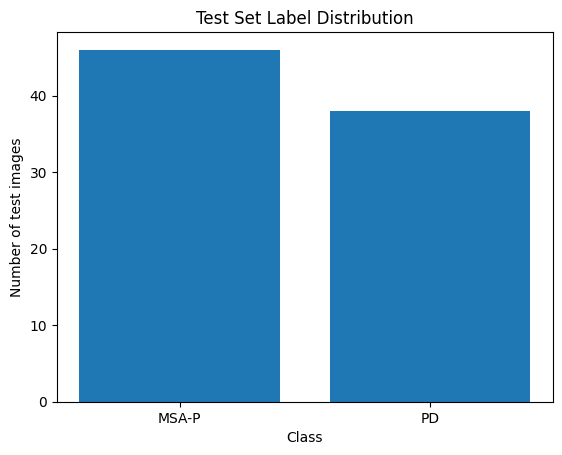

Label 0 (MSA-P): 46 images
Label 1 (PD): 38 images
Label 0 (MSA-P) is: 0.5476190476190477
Label 1 (PD) is: 0.4523809523809524


In [32]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size = cfg.get_test_ratio(), #cfg.data_splitting["test_set_size"],
    stratify=labels,
    random_state=42
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
print("train images paths:", train_images_paths)
print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
print(test_images_paths)
print(type(train_images_paths))


plt.bar([class_names[label] for label in unique_labels], counts)
plt.xlabel("Class")
plt.ylabel("Number of test images")
plt.title("Test Set Label Distribution")
plt.show()

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}): {count} images")

for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({class_names[label]}) is: {count/test_true_labels_np.shape[0]}")

In [34]:
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id).astype(str)

display(df)

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first()

unique_pat_ids = patient_label_df["patient_id"].values  # need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

patient_label_df

,image_path,label,patient_id
0,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,1,7787
1,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,1,7318
2,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,1,6366
3,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,1,6651
4,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,1,6690
...,...,...,...
550,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,0,6593
551,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,0,6663
552,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,0,7343
553,/home/zano/Documents/TESI/FOLDER_CINECA/data/S...,0,5435


Unique patient IDs: ['4092' '5435' '5463' '5717' '5745' '5753' '5767' '5776' '5954' '5978'
 '5992' '5996' '6008' '6046' '6060' '6179' '6237' '6258' '6308' '6311'
 '6323' '6326' '6337' '6340' '6351' '6363' '6366' '6375' '6383' '6424'
 '6427' '6459' '6485' '6571' '6577' '6593' '6599' '6616' '6651' '6657'
 '6663' '6690' '6696' '6749' '6773' '6791' '7114' '7132' '7155' '7229'
 '7284' '7318' '7343' '7461' '7544' '7689' '7781' '7787' '7811']
Number of unique patients: 59
Unique patient labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0]


,patient_id,label
0,4092,0
1,5435,0
2,5463,0
3,5717,0
4,5745,0
5,5753,0
6,5767,0
7,5776,0
8,5954,0
9,5978,0


## BYOL & SIMSIAM

BYOL (Bootstrap Your Own Latent) is another Self-Supervised Learning (SSL) approach that aims to learn meaningful representations from unlabeled data. Unlike SimCLR, BYOL does not require negative samples, which simplifies the training process and reduces the need for large batch sizes.

The goals of BYOL are:
* Learn robust and meaningful embeddings from microscopy images.
* Improve generalization by leveraging structural patterns in the data.

The implementation consists of:
* A BYOL dataset returning augmented pairs.
* Using a target network and an online network to learn representations by minimizing the difference between their outputs.
* Training a ResNet-based BYOL model with a predictor network to improve performance.

Once the model is trained:
* The target network is discarded.
* The online network is fine-tuned with labeled data using a linear classifier.

BYOL improves upon SimCLR in several ways:
* It does not require negative samples, reducing the need for large batch sizes.
* It is less sensitive to the choice of data augmentations.
* It can achieve competitive performance with smaller batch sizes and less computational resources.

### Problems of BYOL
* Still computationally expensive, though less so than SimCLR.
* The quality of learned representations depends on the quality and diversity of the unlabeled data.
* May not work well if the unlabeled data is very different from the labeled data.

Note: the Online network is also called student while the target is called teacher

![alt text](image.png)

![image.png](attachment:image.png)

Training Loop in a Nutshell
1. Augment your Image Twice

    For each sample x, create two augmented versions: x1 and x2.
2. Forward Pass

    Student sees x1 → outputs z1 (encoder + projector), then p1 (predictor).
    
    Teacher sees x2 → outputs z2 (encoder + projector).
3. Loss Function

    - BYOL aims to match p1 with z2 (stop-gradient on the teacher side).
    - Symmetry: Then do the reverse pass (Teacher sees x1, Student sees x2) and combine losses.
    - Final loss is a mean squared error between normalized p1 and z2, plus the symmetrical term.

4. Update Student Weights

    - Standard backprop on the Student network.

5. Momentum Update

    - Update the Teacher’s weights with the exponential moving average.
6. Repeat for all images in the dataset.

    - Typically we do many epochs to learn stable representations.

* implement SIMCLR, BYOL, MOCO, BIG SSL MODEL
* Evaluate resulted features via K-NN, K-mean, Linear classifier

<span style="font-size: 1.5em;">**DOWNSTREAM CLASSIFICATION**</span>

After you’ve done BYOL pretraining for some epochs:

1. Freeze the BYOL encoder (i.e., model.online_encoder).
2. Add a classifier head for PD vs. MSA.
3. Train that classifier with your limited labeled data.

In [13]:
## TODO try Patch-based training for BYOL. Extract multiple patches from each 2D MIP to effectively increase your dataset size.
## TODO Using pretrained 2D ResNet weights as a starting point, then apply BYOL (or SSL more in general).
## TODO choosing the right augmentations

### USING THE REPO BYOL (https://github.com/lucidrains/byol-pytorch)

In [39]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager

yaml_path = f"/home/zano/Documents/TESI/FOLDER_CINECA/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = None # "imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "monai" # or "torchvision" or "monai"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

Configuration loaded from /home/zano/Documents/TESI/FOLDER_CINECA/configs/4c/base.yaml
Configuration: {'dataset': {'class_names': ['MSA-P', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 8, 'lr_discovery_folds': 4}, 'data_augmentation': {'resize_spatial_size': [512, 512], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1, 'crop_size': [256, 256], 'use_color_transforms': True, 'intensity_augmentation_preset': 'light', 'use_crop': False, 'crop_percentage': 0.95}, 'data_loading': {'batch_size': 32, 'num_workers': 4}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 4, 'out_channels': 2, 'dropout_prob': 0.1, 'patch_size': [16, 16], 'library': 'torchvision'}, 'training': {'num_epochs': 50, 'early_stopping_patience': 2, 'mixup_alpha': 0.2, 'oversample': True, 'unders

In [ ]:
from monai.transforms import (
    Compose,
    # EnsureChannelFirstd,
    Resized,
    ScaleIntensityd,
    RandFlip,                    
    RandRotate90,  
    EnsureTyped,              
)
from monai.transforms.utility.dictionary import LambdaD

from monai.transforms.croppad.array import RandSpatialCropSamples  # pure sampler
from monai.data.grid_dataset import PatchDataset
import matplotlib.pyplot as plt
import torch, itertools, math, numpy as np

# ------------------------------------------------------------------
# a) 1‑per‑image dicts with a path under key "image"
# ------------------------------------------------------------------

dataset_ssl = [{"image": path} for path in ssl_images_paths_np]

# ------------------------------------------------------------------
# b) image‑level transforms 
# ------------------------------------------------------------------
from utils.transformations_functions import from_GBR_to_RGB
from classes.CustomTiffFileReader import CustomTiffFileReader

img_tf = Compose([
    CustomTiffFileReader(keys=["image"]), # loads the image from the path as a numpy array (C,H,W) in GBR format
    EnsureTyped(keys=["image"], data_type="tensor", dtype=torch.float32), # Ensure image is a tensor
    LambdaD(keys="image", func=from_GBR_to_RGB),
    # EnsureChannelFirstd(keys="image"),
    Resized(keys="image", spatial_size=(512, 512)),
    ScaleIntensityd(keys="image"),
])

# ------------------------------------------------------------------
# c) patch sampler : 8 random 256×256 crops — pure (non‑dict) version
# ------------------------------------------------------------------
sampler = RandSpatialCropSamples(
    roi_size=(256, 256),
    num_samples=8,
    random_center=True,
    random_size=False,
)

# ------------------------------------------------------------------
# d) patch‑level augments
# ------------------------------------------------------------------
    
patch_tf = Compose([
    # RandChannelShift(max_shift=15, prob=0.70),
    RandFlip(spatial_axis=0, prob=0.5),  
    RandFlip(spatial_axis=1, prob=0.5),
    RandRotate90(max_k=3, prob=0.5),
])

# ------------------------------------------------------------------
# e) PatchDataset – extract the Tensor, sample, then augment
# ------------------------------------------------------------------
patch_ds = PatchDataset(
    data=dataset_ssl,                                             # use named arg `data`
    # dataset=img_ds,                                             # use named arg `dataset`
    samples_per_image=8,                                        # produces 8 patches per image
    patch_func=lambda d: sampler(img_tf(d)["image"]),           # <-- pull out d["image"]
    transform=patch_tf,                                         # augment each pure Tensor
)
#testing porpouses
first_batch = next(iter(patch_ds))
print(f"Batch type: {type(first_batch)}") #Batch type: <class 'monai.data.meta_tensor.MetaTensor'>
print(f"Images shape: {first_batch.shape}") # Batch shape: torch.Size([8, 3, 256, 256])

# ------------------------------------------------------------------
# helper to visualise the 8 patches from image `img_idx`
# ------------------------------------------------------------------
def show_patches(
    ds,
    img_idx: int = 0,
    n_patches: int = 8,
    show_original: bool = False
):
    """
    Display random cropped patches (and optionally the original image)
    for the image at index `img_idx` in a PatchDataset.

    Parameters
    ----------
    ds : monai.data.PatchDataset
        A PatchDataset yielding Tensor patches (C, H, W).
    img_idx : int, optional
        Zero-based index of which source image to pull patches from.
        Default is 0.
    n_patches : int, optional
        How many patches were sampled per image (so for slicing the iterator).
        Default is 8.
    show_original : bool, optional
        If True, will display the full pre‑processed image before the patches.
        Default is False.

    Raises
    ------
    ValueError
        If `img_idx` is out of range (i.e. no patches found).
    """
    # -- optionally show the original full‐image (after img_tf) --
    if show_original:
        # pull the same dict you used to build patch_ds
        d = dataset_ssl[img_idx] # get the img_idx element of the list of dictionaries ie  {"image": path_idx}
        # print(d) #{ "image": "path"}
        image_tensor = img_tf(d)["image"]           # apply the image-level transforms to the image ternsor ie d["image"] ie load the tensor associated to that path
        print(f"Original image tensor shape #{img_idx}: {image_tensor.shape}") # Print the shape of the tensor
        # visualize_tiff(img_ds[img_idx]["image"]) # Use your custom function to visualize the TIFF image
        # print(f"Original image shape #{img_idx}: {d["image"].shape}")
        img = image_tensor.cpu().numpy().transpose(1, 2, 0)  # H×W×C to plot
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Original image #{img_idx}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # -- now grab the n_patches for that image index --
    start = img_idx * n_patches
    end   = start + n_patches
    stream = itertools.islice(iter(ds), start, end) # iterator of Tensors
    patches = [p.cpu() for p in stream] # list of Tensors

    if not patches:
        raise ValueError(f"img_idx {img_idx} out of range (no patches)")

    # -- plot the patches in a grid --
    n_cols = 4
    n_rows = math.ceil(n_patches / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(3 * n_cols, 3 * n_rows))
    for ax, patch in zip(axes.flat, patches):
        img = patch.numpy().transpose(1, 2, 0)  # H×W×C
        ax.imshow(img)
        ax.axis("off")
        

    # blank out any leftover axes
    for ax in axes.flat[len(patches):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# show original + patches from the 3rd image
show_patches(patch_ds, img_idx=15, n_patches=8, show_original=True)

In [42]:
from monai.data import Dataset, DataLoader
from numpy import stack
from classes.PrintShapeTransform import PrintShapeTransform
from classes.CustomTiffFileReader import CustomTiffFileReader

base_transforms = train_transforms

# Wrap your patch_ds with a custom collate function that returns dictionaries
# it tells the DataLoader how to combine the individual patches into a batch of dictionaries
# alternative to this is just to not use dictinary transform but array transforms 
def dict_collate_fn(batch):
    #stack the images in the batch and return a dictionary
    stacked_images = torch.stack(batch, 0)
    dummy_labels = torch.zeros(stacked_images.size(0), dtype=torch.long) # Dummy label, not used in SSL
    return {"image": stacked_images, "label": dummy_labels} # This assumes each item in the batch is a dictionary with an "image" key.


BATCH_SIZE = 16  # Define your batch size

# Create the patch-based DataLoader
train_loader_patch_ds = DataLoader(
    patch_ds,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    collate_fn=dict_collate_fn  #tells the DataLoader how to combine the individual patches into a batch of dictionaries
)

#testing porpouses
# first_batch = next(iter(train_loader_patch_ds))
# print(f"Batch type: {type(first_batch)}") #Batch type: <class 'dict'>
# print(f"Batch keys: {first_batch.keys()}") #dict_keys(['image','label'])
# print(f"Images shape: {first_batch['image'].shape}")  #torch.Size([16, 3, 256, 256])

# Create the full-image DataLoader
from utils.train_functions import make_unlabeled_loader
train_loader_full_ds = make_unlabeled_loader(
    image_paths=ssl_images_paths_np,
    transforms=base_transforms,
    cfg=cfg,
    shuffle=True,
)
# print("FULL IMAGE DATASET")
# first_batch = next(iter(train_loader_full_ds))
# print(f"Batch type: {type(first_batch)}") #Batch type: <class 'dict'>
# print(f"Batch keys: {first_batch.keys()}") #dict_keys(['image'])
# print(f"Images shape: {first_batch['image'].shape}")  #torch.Size([16, 3, 256, 256])
# print(type(train_loader))

In [43]:
import ipywidgets as widgets
from IPython.display import display
# Dictionary to map dropdown options to loaders
loader_options = {
    "Patch DataLoader": train_loader_patch_ds,
    "Full Image DataLoader": train_loader_full_ds,
}

# Dropdown widget for loader selection
loader_dropdown = widgets.Dropdown(
    options=list(loader_options.keys()),
    value="Patch DataLoader",
    description="Train Loader:",
    style={'description_width': 'initial'},
)

# Variable to hold the selected loader
train_loader = loader_options[loader_dropdown.value]

def on_loader_change(change):
    """
    Callback to update the train_loader variable when the dropdown changes.
    """
    global train_loader
    train_loader = loader_options[change['new']]
    print(f"train_loader set to: {change['new']} ({type(train_loader)})")

# Attach the callback to the dropdown
loader_dropdown.observe(on_loader_change, names='value')

display(loader_dropdown)
print(f"Initial train_loader: {loader_dropdown.value} ({type(train_loader)})")

Dropdown(description='Train Loader:', options=('Patch DataLoader', 'Full Image DataLoader'), style=Description…

Initial train_loader: Patch DataLoader (<class 'monai.data.dataloader.DataLoader'>)


In [55]:
# Check the type of the train_loader and shape of the returned batches
print(type(train_loader))  # Should be a DataLoader
for batch in train_loader:
    print(f"Batch type: {type(batch)}")  # Should be a dictionary
    print(f"Batch keys: {batch.keys()}")  # Should contain 'image' and possibly 'label'
    print(f"Images shape: {batch['image'].shape}")  # Should be [BATCH_SIZE, C, H, W]
    if num_input_channels == 3:
        assert batch['image'].shape == torch.Size([BATCH_SIZE, 3, 256, 256]), "Batch size mismatch!"
    else:   
        assert batch['image'].shape == torch.Size([BATCH_SIZE, 4, 256, 256]), "Batch size mismatch!"
    break  # Just show the first batch for now

<class 'monai.data.dataloader.DataLoader'>
Batch type: <class 'dict'>
Batch keys: dict_keys(['image', 'label'])
Images shape: torch.Size([16, 4, 256, 256])


In [20]:
# import kornia.augmentation as K
# import kornia.filters as KF

# _final_resize = K.Resize(size=(256, 256))

# # ──────────────────────────────
# # View 1 — “global crop”
# # ──────────────────────────────
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Common safeguard: always finish at 256 × 256
# _final_resize = K.Resize(size=(256, 256), antialias=True)

# # ──────────────────────────────
# # View 1 — “global crop”
# # ──────────────────────────────
# augment_fn = nn.Sequential(
#     # Multi-scale global crop (55–100 % area)
#     K.RandomResizedCrop(
#         size=(256, 256), scale=(0.55, 1.0), ratio=(1.0, 1.0), p=1.0
#     ),

#     # Geometric invariances
#     K.RandomHorizontalFlip(p=0.5),
#     K.RandomVerticalFlip(p=0.5),
#     K.RandomRotation(degrees=180.0, resample="bilinear", p=0.5),

#     # # Mild tissue-like deformation
#     # K.RandomElasticTransform(
#     #     kernel_size=(75, 75),      # coarser grid → smoother field
#     #     sigma=(9.0, 13.0),         # keep σ ≈ kernel_size / 8
#     #     alpha=(2.0, 4.0),          # 2-4 px average displacement
#     #     p=0.20,
#     #     align_corners=False,
#     #     padding_mode="border",
#     # ),

#     # Image-formation perturbations
#     K.RandomGaussianBlur(kernel_size=(5, 5), sigma=(0.2, 1.2), p=0.50),
#     # K.RandomPoissonNoise(lam=(4.0, 12.0), p=0.40),
#     K.RandomGaussianNoise(mean=0.0, std=0.015, p=0.40),

#     # Intensity jitter (per-channel invariance)
#     K.ColorJiggle(brightness=(0.8, 1.2), contrast=(0.8, 1.2), p=0.40),
#     # K.RandomGamma(gamma=(0.8, 1.2), p=0.30),

#     # Channel robustness
#     K.RandomChannelDropout(num_drop_channels=1, p=0.20),
#     # Occlusion regularisation  
#     K.RandomErasing(
#         scale=(0.02, 0.08),
#         ratio=(0.3, 3.3),
#         same_on_batch=False,
#         # value="random",  # coloured blocks instead of black
#         p=0.15,
#     ),
    

#     _final_resize,  # ensure 256 × 256 output
# ).to(device)

# # ──────────────────────────────
# # View 2 — “local crop + deformation”
# # ──────────────────────────────
# augment_fn2 = nn.Sequential(
#     # Tighter crop (35–60 % area)
#     K.RandomResizedCrop(
#         size=(256, 256), scale=(0.35, 0.60), ratio=(1.0, 1.0), p=1.0
#     ),

#     # Mild illumination & contrast jitter before geometry
#     K.ColorJiggle(brightness=(0.85, 1.15), contrast=(0.85, 1.15), p=0.50),

#     # Geometric invariances
#     K.RandomAffine(
#         degrees=0.0,
#         translate=(0.05, 0.05),
#         scale=(0.90, 1.10),
#         shear=(3.0, 3.0),
#         padding_mode="border",
#         p=0.50,
#     ),
    
#     # K.RandomElasticTransform(
#     #     kernel_size=(75, 75),      # coarser grid → smoother field
#     #     sigma=(9.0, 13.0),         # keep σ ≈ kernel_size / 8
#     #     alpha=(2.0, 4.0),          # 2-4 px average displacement
#     #     p=0.20,
#     #     align_corners=False,
#     #     padding_mode="border",
#     # ),

#     # Focus & noise perturbations
#     K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0), p=0.50),
#     # K.RandomPoissonNoise(lam=(4.0, 12.0), p=0.40),
#     K.RandomGaussianNoise(mean=0.0, std=0.020, p=0.60),

#     # Channel robustness
#     K.RandomChannelDropout(num_drop_channels=1, p=0.30),

#     # Occlusion regularisation
#     K.RandomErasing(
#         scale=(0.03, 0.10),
#         ratio=(0.3, 3.3),
#         same_on_batch=False,
#         # value="random",
#         p=0.20,
#     ),

#     _final_resize,
# ).to(device)

To fetch the embeddings or the projections, you simply have to pass in a return_embeddings = True flag to the BYOL learner instance


```python
resnet = models.resnet50(pretrained=True)

learner = BYOL(
    resnet,
    image_size = 256,
    hidden_layer = 'avgpool'
)

imgs = torch.randn(2, 3, 256, 256)
projection, embedding = learner(imgs, return_embedding = True)
```

or

```python

# 1) Load your BYOL-pretrained ResNet
model = models.resnet50(pretrained=False)
model.load_state_dict(torch.load('byol_pretrained_resnet.pth'))

# 2) (Optional) Remove the final FC if you want raw 2048-d features
model.fc = nn.Identity()

model = model.to('cuda')
model.eval()

# 3) Pass images through for embeddings
with torch.no_grad():
    embeddings = model(your_images_tensor)  # shape: (B, 2048) if you removed fc
    ```

In [61]:
from configs.ConfigLoader import ConfigLoader
import utils.transformations_functions as tf
from classes.ModelManager import ModelManager
PROJ_ROOT = os.getenv("PROJ_ROOT", "/home/zano/Documents/TESI/FOLDER_CINECA")

yaml_path = f"{PROJ_ROOT}/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = None#"imagenet" if transfer_learning else "" # 'microscopynet' or "imagenet"
model_library = "monai" # or "torchvision" or "monai"
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
print(f"Number of classes in the dataset: {num_classes}")

# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

print(model)
print(cfg.get_model_input_channels())

Configuration loaded from /home/zano/Documents/TESI/FOLDER_CINECA/configs/4c/base.yaml
Configuration: {'dataset': {'class_names': ['MSA-P', 'PD']}, 'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 8, 'lr_discovery_folds': 4}, 'data_augmentation': {'resize_spatial_size': [512, 512], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1, 'crop_size': [256, 256], 'use_color_transforms': True, 'intensity_augmentation_preset': 'light', 'use_crop': False, 'crop_percentage': 0.95}, 'data_loading': {'batch_size': 32, 'num_workers': 4}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 4, 'out_channels': 2, 'dropout_prob': 0.1, 'patch_size': [16, 16], 'library': 'torchvision'}, 'training': {'num_epochs': 50, 'early_stopping_patience': 2, 'mixup_alpha': 0.2, 'oversample': True, 'unders

In [39]:
from classes.MonaiNdTransformAdapter import MonaiNdTransformAdapter
from utils.ssl.byol_transformation_functions import get_byol_transforms_nd

normalize_intensity = False  # Set to True if you want to normalize intensity
monai_view1_compose, monai_view2_compose = get_byol_transforms_nd(cfg, normalize_intensity=normalize_intensity)
type_of_transform = "monai_non_dict"
# // Wrap the MONAI Compose objects
wrapped_monai_view1_transform = MonaiNdTransformAdapter(monai_view1_compose)
wrapped_monai_view2_transform = MonaiNdTransformAdapter(monai_view2_compose)

# // Determine the device (consistent with your Kornia setup and BYOL learner)
# This device should be the same as the one used for your Kornia augmentations and the BYOL learner
# You might already have 'device' defined from cell '9288ea70' or when setting up the model
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# // Move the wrapped MONAI transforms to the device
augment_fn = wrapped_monai_view1_transform.to(current_device)
augment_fn2 = wrapped_monai_view2_transform.to(current_device)

# // Now, 'augment_fn' and 'augment_fn2' are nn.Modules on the correct device,
# // and can be passed to the BYOL learner in cell 'f5012178'.
# // This replaces the previous assignment:
# // augment_fn=monai_view1_transform
# // augment_fn2=monai_view2_transform

print(f"MONAI augment_fn type: {type(augment_fn)}, device: {next(augment_fn.parameters()).device if list(augment_fn.parameters()) else 'No parameters, device assumed from input'}")
print(f"MONAI augment_fn2 type: {type(augment_fn2)}, device: {next(augment_fn2.parameters()).device if list(augment_fn2.parameters()) else 'No parameters, device assumed from input'}")

MONAI augment_fn type: <class 'classes.MonaiNdTransformAdapter.MonaiNdTransformAdapter'>, device: No parameters, device assumed from input
MONAI augment_fn2 type: <class 'classes.MonaiNdTransformAdapter.MonaiNdTransformAdapter'>, device: No parameters, device assumed from input


In [40]:
from utils.ssl.byol_transformation_functions import get_byol_transforms_dict
from classes.MonaiDictTransformAdapter import MonaiDictTransformAdapter

# Get the MONAI Compose objects for dictionary-based transforms
normalize_intensity = False  # Set this based on your needs
monai_view1_dict_transform, monai_view2_dict_transform = get_byol_transforms_dict(cfg, normalize_intensity=normalize_intensity)
type_of_transform = "monai_dict"
# Wrap the MONAI Compose objects
# You might need to inspect monai_view1_dict_transform to confirm the exact image key if it's not "image"
# For example, if your get_byol_transforms_dict creates transforms that use a different key, adjust "image" accordingly.
wrapped_monai_view1_transform = MonaiDictTransformAdapter(monai_view1_dict_transform, image_key="image")
wrapped_monai_view2_transform = MonaiDictTransformAdapter(monai_view2_dict_transform, image_key="image")

# Determine the device
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Move the wrapped MONAI transforms to the device
augment_fn = wrapped_monai_view1_transform.to(current_device)
augment_fn2 = wrapped_monai_view2_transform.to(current_device)

In [ ]:
@torch.no_grad()
def viz_augmented_views_monai(
    sample_idx: int,
    augment_fn,
    augment_fn2,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    num_images: int = 1,
    dataset_ssl=dataset_ssl,  # Reference your dataset_ssl from earlier
    img_loader_transform=img_tf # Reference img_tf for loading original images
):
    """
    Visualize original images and their augmented views using MONAI dictionary-based transforms
    that expect an already loaded image tensor in their input dictionary.

    Parameters:
    -----------
    sample_idx : int
        Index of the sample in dataset_ssl to start visualization from.
    augment_fn : monai.transforms.Compose
        The first MONAI dictionary-based augmentation pipeline (e.g., from get_byol_transforms_dict).
        It expects an input dictionary like {"image": torch.Tensor, "label": ...}
        where the "image" is an already loaded and preprocessed tensor, and
        returns an augmented dictionary {"image": torch.Tensor, ...}.
    augment_fn2 : monai.transforms.Compose
        The second MONAI dictionary-based augmentation pipeline, with the same
        characteristics as augment_fn.
    device : str or torch.device, optional
        The device to move tensors to before applying augmentations if necessary,
        though dictionary transforms might handle device internally or expect CPU input.
        Defaults to "cuda" if available, otherwise "cpu".
    num_images : int, optional
        Number of images to show. Defaults to 1.
    dataset_ssl : List[Dict[str, str]], optional
        A list of dictionaries, where each dictionary must have an "image" key
        with a file path string. Defaults to the `dataset_ssl` in the global scope.
    img_loader_transform : monai.transforms.Compose, optional
        A MONAI dictionary-based transform pipeline for loading and initial
        preprocessing of images from paths (e.g., global `img_tf`).
        It expects a Dict {"image": path_str, ...} and returns a
        Dict {"image": torch.Tensor, ...}. Defaults to `img_tf`.

    Returns:
    --------
    Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        A tuple containing:
        - orig_batch: Batch of original images as a torch.Tensor
                      (shape (num_images, C, H, W)), on CPU.
        - view1_batch: Batch of augmented view1 images as a torch.Tensor
                       (shape (num_images, C, H, W)), likely on CPU or device
                       depending on the last transform in augment_fn.
        - view2_batch: Batch of augmented view2 images as a torch.Tensor
                       (shape (num_images, C, H, W)), similar to view1_batch.
    """
    # Get the file paths for the images to visualize
    paths = []
    for i in range(sample_idx, min(sample_idx + num_images, len(dataset_ssl))):
        paths.append(dataset_ssl[i]["image"])  # Get original file paths

    # Load original images and prepare input dictionaries for augmentation
    loaded_image_dicts = []
    for path in paths:
        # img_loader_transform loads the image from path and returns a dict {"image": tensor, "label": ...}
        # The tensor is typically on CPU after loading.
        # We add a dummy label as some MONAI dict transforms might expect it.
        loaded_dict = img_loader_transform({"image": path, "label": 1})
        loaded_image_dicts.append(loaded_dict)
    
    orig_batch_cpu = torch.stack([d["image"] for d in loaded_image_dicts]) # Shape: (num_images, C, H, W), on CPU

    # Apply augmentation pipelines
    view1_augmented_tensors_list = []
    for loaded_dict in loaded_image_dicts:
        # Create a copy to avoid modifying the original loaded_dict if augment_fn works in-place
        input_dict_for_aug = {k: v.clone().to(device) if isinstance(v, torch.Tensor) else v for k, v in loaded_dict.items()}
        # Or, if augment_fn expects CPU tensors and handles device transfer internally:
        # input_dict_for_aug = {k: v.clone() if isinstance(v, torch.Tensor) else v for k, v in loaded_dict.items()}
        
        augmented_dict = augment_fn(input_dict_for_aug)
        view1_augmented_tensors_list.append(augmented_dict["image"])
    
    view1_batch = torch.stack(view1_augmented_tensors_list)

    view2_augmented_tensors_list = []
    for loaded_dict in loaded_image_dicts:
        input_dict_for_aug = {k: v.clone().to(device) if isinstance(v, torch.Tensor) else v for k, v in loaded_dict.items()}

        augmented_dict = augment_fn2(input_dict_for_aug)
        view2_augmented_tensors_list.append(augmented_dict["image"])
        
    view2_batch = torch.stack(view2_augmented_tensors_list)

    # Plot the results
    n_rows = num_images
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4 * n_rows))
    titles = ["Original", "View 1", "View 2"]
    
    for r in range(n_rows):
        imgs_to_plot = [orig_batch_cpu[r], view1_batch[r], view2_batch[r]]
        
        for c, img_tensor in enumerate(imgs_to_plot):
            ax = axes[r, c] if n_rows > 1 else axes[c]
            img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)  # CHW to HWC
            ax.imshow(np.clip(img_np, 0, 1))
            
            if r == 0:
                current_title = f"{titles[c]} ({img_tensor.device})"
                ax.set_title(current_title)
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    return orig_batch_cpu, view1_batch, view2_batch

# Visualize transformations on a few samples
viz_augmented_views_monai(0, monai_view1_dict_transform, monai_view2_dict_transform, num_images=3)

In [ ]:
from byol_pytorch import BYOL
from torchvision import models
import time
# resnet = models.resnet50(weights = None)  # or pretrained=True if you like
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

#usage Simply plugin your neural network, specifying 
# (1) the image dimensions
# (2) the name (or index) of the hidden layer, 
# whose output is used as the latent representati
# this library will use the augmentations from the SimCLR paper (which is also used in the BYOL paper).
# learner = BYOL(
#     resnet,
#     image_size = 256,          # the height & width of your input images
#     augment_fn = custom_augment_fn,
#     augment_fn2 = custom_augment_fn,  # or define a second pipeline if desired
#     hidden_layer = 'avgpool',  # output layer used for representation
#     # projection_size = 256,     # defaults to 256
#     # projection_hidden_size = 4096,
#     # moving_average_decay = 0.99
# )

simsiam = True

if not simsiam:
    print("BYOL")
    learner = BYOL(
        net=model,
        image_size=256,           # must match your input size
        hidden_layer='avgpool',   # layer to extract embeddings from in ResNet
        augment_fn=augment_fn,   # our custom random transforms
        augment_fn2=augment_fn2,  # can define a second if you want different augmentations
        projection_size=256,
        projection_hidden_size=4096,
        moving_average_decay=0.99
    )
else:
    print("SimSiam")
    learner = BYOL(
        net=model,
        image_size=256,  # must match your input size
        hidden_layer=-2, #or "avgpool"   # layer to extract embeddings from in ResNet
        augment_fn=augment_fn,   # our custom random transforms
        augment_fn2=augment_fn2,  # can define a second if you want different augmentations
        # projection_size=256,
        # projection_hidden_size=4096,
        # moving_average_decay=0.99
        use_momentum=False, # This is the main difference from byol
    ) 

device = "cuda" if torch.cuda.is_available() else "cpu"
learner = learner.to(device)
optimizer = optim.Adam(learner.parameters(), lr=1e-4)
scaler = torch.GradScaler("cuda")  # for mixed precision training

start_time = time.time()
#Encoder Pre-training loop
patience          = 25          
best_train_loss   = float("inf")
epochs_no_improve = 0
best_state_dict   = None

num_epochs = 120
for epoch in range(1, num_epochs + 1):
    learner.train()
    total_loss = 0.0
    for batch in train_loader:
        #load the images from the batch ()
        imgs = batch["image"].to(device)
        # print(f"Batch shape: {imgs.shape}")  # Should be [batch_size, 3, 256, 256]

        with torch.autocast(device_type=device, dtype=torch.float16):
            loss = learner(imgs)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(learner.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        if not simsiam:
            learner.update_moving_average()

        total_loss += loss.item() * imgs.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch:3d} | train loss {train_loss:.4f}")

    # ---------- early-stopping on training loss ----------
    if train_loss < best_train_loss - 1e-6:     # 1e-6 = small min_delta
        best_train_loss   = train_loss
        epochs_no_improve = 0
        best_state_dict   = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Stopping: train loss hasn’t improved for {patience} epochs.")
            break

# restore best weights (optional but typical)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

encoder_type = "BYOL" if not simsiam else "SimSiam"
# model = resnet
# model_class_name = model.__class__.__name__
# print(f"Model class name: {model_class_name}")
# print(cfg.get_model_name())

pretrained_backbone_name = f"{encoder_type}_{cfg.get_model_name()}_{type_of_transform}_normInt:{normalize_intensity}_inputChannels:{cfg.get_model_input_channels()}_batchSize: {BATCH_SIZE}"
STABLE_BACKBONE_PATH = pretrained_backbone_name + ".pth"
torch.save(model.state_dict(), STABLE_BACKBONE_PATH)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

### LOADING PRE-TRAINED ENCODER

In [42]:
import copy
# 7) Reload the pretrained backbone
encoder_type = "byol"
byol_encoder = copy.deepcopy(model) # Extract the encoder part not taking into consideration the projection head
# 3) Load your pre-trained SSL weights
state_dict = torch.load(STABLE_BACKBONE_PATH, map_location=device)
byol_encoder.load_state_dict(state_dict)
byol_encoder = byol_encoder.to(device)
print(byol_encoder)
# 8) Use encoder for downstream tasks
# small test to see the encoder output dimension
from utils.train_functions import remove_projection_head
print("Removing projection head from the encoder...")
print(byol_encoder)

import copy
# 4) (Optional) Quick check of encoder output dim
encoder = copy.deepcopy(byol_encoder).eval()  # Set the encoder to evaluation mode
print(cfg.get_image_shape())
with torch.no_grad():
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    encoder_out = byol_encoder(test_input).flatten(start_dim=1)
    model_without_projection = remove_projection_head(copy.deepcopy(byol_encoder))  # Set the encoder to evaluation mode
    test_input = torch.zeros(1, 3, cfg.get_image_shape()[0], cfg.get_image_shape()[1], device=device)
    feats = model_without_projection(test_input).flatten(start_dim=1)
print(f"Detected encoder output dimension: {encoder_out.shape[1]}")
print(f"Detected encoder output dimension once removed classification head: {feats.shape[1]}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### LOADING RANDOM INITIALIZED ENCODER

In [43]:
from utils.reproducibility_functions import set_global_seed

# Set seed for reproducibility
set_global_seed(42)

In [44]:
from utils.reproducibility_functions import models_equal_hash
byol_encoder_notPretrained, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
byol_encoder_notPretrained2, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
are_equally_initialized = models_equal_hash(byol_encoder_notPretrained, byol_encoder_notPretrained2)
print(f"Are the two encoders equally initialized? {are_equally_initialized}")

Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Using Torchvision for model instantiation.
pretrained_weights?  pretrained? False
Building torchvision ResNet18...
Are the two encoders equally initialized? True


In [ ]:
#LOAD WITH RANDOMLY INITIALIZED BACKBONE TO TEST IF SSL IS WORKING
byol_encoder_notPretrained, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
encoder_type = "NOSSL"

def _remove_linear_probe_head(backbone):
        # if isinstance(self.backbone.fc, LinearProbeHead):
        # print(self.backbone.fc.__class__.__name__)
        if hasattr(backbone, "fc"):
            if  backbone.fc.__class__.__name__ == "LinearProbeHead":
                print("removing linear probe head")
                backbone.fc = nn.Identity()
            
        elif hasattr(backbone, "classifier"):
            if backbone.classifier.__class__.__name__ == "LinearProbeHead":
                backbone.classifier = nn.Identity()
        else:
            raise RuntimeError(
                    "Could not remove linear probe head"
                )
            
_remove_linear_probe_head(byol_encoder_notPretrained)
print(byol_encoder_notPretrained)

### DOWNSTREAM CLASSIFICATION

- Create a new ResNet with the same architecture (4-channel mod if needed).
- Load the improved weights into it.
- Replace the final layer with a custom classification head.
- Train/Fine-tune on your labeled data (50 PD, 50 MSA).

In [ ]:
from utils.train_functions import BaseSSLClassifier, SSLClassifierModule, nested_cv_stratified_by_patient, solve_cuda_oom
import copy
from utils.train_functions import  SSLClassifierModule

FREEZE_ENCODER= True  # Set to True if you want to freeze the encoder
encoders = [byol_encoder, byol_encoder_notPretrained]
bool_list = [True, False] 
for encoder in encoders:
    for FREEZE_ENCODER in bool_list:
        if encoder == byol_encoder:
            if simsiam:
                encoder_type = "SimSiam"
            else:
                encoder_type = "BYOL"
        else:
            encoder_type = "NOSSL"
            
        def model_factory(lr: float)-> torch.nn.Module:
            """
        Model‐factory that instantiates a fresh SSLClassifierModule
        with the given learning rate.
        """
            fresh_encoder = copy.deepcopy(encoder)
            return SSLClassifierModule(
                encoder=fresh_encoder,     # capture this from your outer scope
                num_classes=2,
                freeze_encoder=FREEZE_ENCODER,
                lr=cfg.get_learning_rate(),
                backbone_output_dim=feats.shape[1],
                # input_shape=input_shape= (1, num_input_channels, 256, 256),  # Adjust as needed (B, C, H, W)
            )

        from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
        # cfg.set_freezed_layer_index(None)
        experiment = NestedCVStratifiedByPatient(
            df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
            pretrained_weights = pretrained_weights,
            class_names = class_names, model_factory=model_factory, num_folds=6
        )
        # cfg.set_freezed_layer_index(None)
        # hold_out_cv = True
        using_cosine_scheduler = False

        per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


        from utils.mlflow_functions import log_SSL_run_to_mlflow
        def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
            """
            Get the index of the best fold based on a specified metric.

            Args:
                outer_fold_test_results (list of dict): List containing test results for 
                    each outer fold. Each element should be a dictionary with metrics 
                    as keys.
                metric (str): The metric name to use for selecting the best fold. 
                    Default is "test_balanced_acc".

            Returns:
                int: The index of the fold with the highest value for the specified metric.

            Example:
                best_idx = get_best_fold_idx(results, metric="test_f1")
            """

            print(outer_fold_test_results)
            best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
            # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
            best_fold_result = outer_fold_test_results[best_fold_idx]
            print(f"Best {metric} Fold Result: {best_fold_result}")
            fold_idx = best_fold_result["fold"]
            return fold_idx

        #loading the best model for the metric selected, it's then used for computing gradcams during logging
        best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
        model_instance_for_logging, _ = experiment._get_model_and_device()
        model_instance_for_logging.eval()
        try:
            model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
        except FileNotFoundError:
            raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
        except Exception as e:
            raise Exception(f"Error loading model weights: {str(e)}")

        # Now, call the logging function:
        train_transforms, val_transforms,_ = experiment.get_current_fold_transforms()
        # Now, call the logging function:
        # or "moco" if using MoCo
        log_SSL_run_to_mlflow(
            environmentFlags=environment_flags,
            cfg=cfg,
            model=model_factory(0.001),  # Pass a dummy model to log the run
            class_names=class_names,
            fold_results=outer_fold_test_results,
            per_fold_metrics=per_fold_training_metrics,
            hold_out_cv=True,
            test_transforms=val_transforms,
            all_images_paths_np=images_paths_np,
            all_labels_np=labels_np,
            test_images_paths_np=test_images_paths_np,
            test_true_labels_np=test_true_labels_np,
            yaml_path=yaml_path,
            color_transforms=color_transforms,
            model_library=model_library,
            encoder_type= encoder_type,
            pretrained_backbone_path = STABLE_BACKBONE_PATH,
            train_transforms=train_transforms,
            # val_transforms=val_transforms,
            freeze_encoder= FREEZE_ENCODER,
            ssl=True,
        )
        solve_cuda_oom()